# Import Library

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms#
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib as mpl

# Hyperparameters

In [2]:
batch_size = 5
learning_rate = 0.05
num_epochs = 5

# Class Dataset and Dataloader

In [3]:
class Dataset(Dataset):
    def __init__(self, root_dir, traj_dir):
        self.root_dir = root_dir
        self.traj_dir = traj_dir
        
        
      
    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.traj_dir[idx])
        traj_path = os.listdir(path)
        num = len(traj_path)
        
        
        traj_data = []
        for i in range(100):
            absolute_path = os.path.join(path, traj_path[i])
            data_i = np.load(absolute_path)
            traj_data.append(data_i)
        #traj_data = np.array(traj_data)
        traj_data = torch.from_numpy(np.array(traj_data)).float()
    
            
        tarj_label = []
        for i in range(num-15, num):
            absolute_path = os.path.join(path, traj_path[i])
            data_i = np.load(absolute_path)
            tarj_label.append(data_i)
        tarj_label = np.array(tarj_label)
        tarj_label = torch.from_numpy(np.array(tarj_label)).float()
       
        
       
            
        return traj_data, tarj_label
            
                    
    def __len__(self):
        return len(self.traj_dir)
                                         

In [4]:
root_dir = '/trajectories'
training_dir = ['t' + str(x)  for x in range (1, 16)] + ['t' + str(x)  for x in range (24, 40)]
testing_dir = ['t' + str(x)  for x in range (16, 24)] + ['t' + str(x)  for x in range (40, 49)]

['t16', 't17', 't18', 't19', 't20', 't21', 't22', 't23', 't40', 't41', 't42', 't43', 't44', 't45', 't46', 't47', 't48']
['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't24', 't25', 't26', 't27', 't28', 't29', 't30', 't31', 't32', 't33', 't34', 't35', 't36', 't37', 't38', 't39']


In [5]:
transform = transforms.Compose([
        transforms.ToTensor(),
])

train_dataset = Dataset(root_dir, training_dir)
test_dataset = Dataset(root_dir, testing_dir)

In [7]:
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True)

# Class Model

In [9]:
class VAE(nn.Module):
    def __init__(self, inChannels=100, featureDim=1*10*10, zDim=50):
        super(VAE, self).__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(inChannels, 50, 24, stride= 20)
        self.encConv2 = nn.Conv2d(50, 1, 24, stride=3)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(1, 50, 24, stride=3)
        self.decConv2 = nn.ConvTranspose2d(50, 15, 24, stride= 20)

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 1*10*10)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 1, 10, 10)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [10]:
net = VAE()
print(net)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

VAE(
  (encConv1): Conv2d(100, 50, kernel_size=(24, 24), stride=(20, 20))
  (encConv2): Conv2d(50, 1, kernel_size=(24, 24), stride=(3, 3))
  (encFC1): Linear(in_features=100, out_features=50, bias=True)
  (encFC2): Linear(in_features=100, out_features=50, bias=True)
  (decFC1): Linear(in_features=50, out_features=100, bias=True)
  (decConv1): ConvTranspose2d(1, 50, kernel_size=(24, 24), stride=(3, 3))
  (decConv2): ConvTranspose2d(50, 15, kernel_size=(24, 24), stride=(20, 20))
)


# Training and Testing

In [11]:
print("Start training VAE...")

all_loss = []
all_loss_list = []
for epoch in range(num_epochs):
    net.train()
    loss1_all = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        out, mu, logVar = net(x)
        KL_divergence = - 0.5 * torch.sum(1+ logVar - mu.pow(2) - logVar.exp())
        loss1 = F.mse_loss(out, y) + KL_divergence
        loss1_all += loss1.item()
        
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()
        
    all_loss.append(loss1_all)
    
    
    loss2_all = 0
        
   
    with torch.no_grad():
        net.eval()
        for batch_idx, (x, y) in enumerate(test_loader):
            pred, mu, logVar = net(x)
            KL_divergence = - 0.5 * torch.sum(1+ logVar - mu.pow(2) - logVar.exp())
            loss2 = F.mse_loss(pred, y) + KL_divergence
            loss2_all += loss2.item()
    
    all_loss_list.append(loss2_all)
        
        
    print('Epoch {}: Loss {}'.format(epoch, loss1_all))
    print('Epoch {}: Loss {}'.format(epoch, loss2_all))

Start training VAE...
Epoch 0: Loss 2.0978972911834717
Epoch 0: Loss 0.35927794873714447
Epoch 1: Loss 0.4926917068660259
Epoch 1: Loss 0.2678610309958458
Epoch 2: Loss 0.2995666153728962
Epoch 2: Loss 0.20348935946822166
Epoch 3: Loss 0.21911178156733513
Epoch 3: Loss 0.1557480599731207
Epoch 4: Loss 0.17445013113319874
Epoch 4: Loss 0.12889033555984497


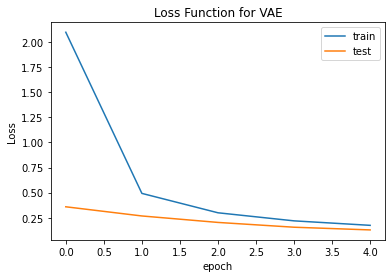

In [13]:
plt.plot(all_loss, label='train')
plt.plot(all_loss_list, label = 'test')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss Function for VAE')
plt.legend()

In [48]:
test_loader = DataLoader(dataset = test_dataset, batch_size=1, shuffle=True)

MSE_loss = []
for batch_idx, (x, y) in enumerate(test_loader):
    pred, mu, logVar = net(x)
    loss = F.mse_loss(pred, y)
    MSE_loss.append(loss.item())

Text(0.5, 1.0, 'MSE of all 16 trajectories')

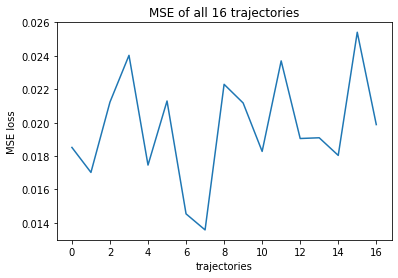

In [28]:
plt.plot(MSE_loss)
plt.xlabel('trajectories')
plt.ylabel('MSE loss')
plt.title('MSE of all 16 trajectories')